In [1]:
import sim
import util
import torch
from IPython.display import clear_output
from models import GibbsGMM, PyroLDA

clear_output()

In [ ]:
class GibbsLDA():
    def __init__(self, n_topics):
        self.n_topics = n_topics

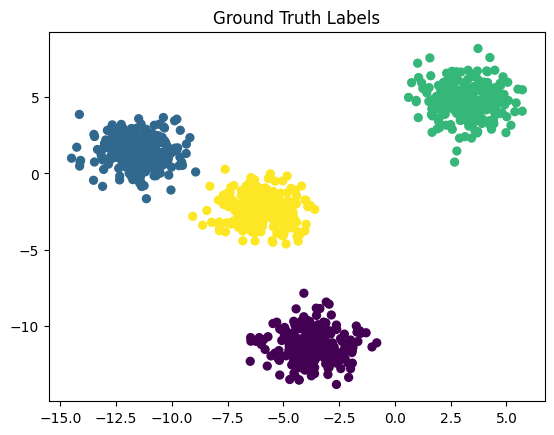

In [2]:
N_SAMPLES = 1000
N_FEATURES = 100
N_TOPICS = 4
SCALE = 1
DISCRETIZE = False
SHUFFLE = True

if DISCRETIZE:
    X, X_labels, vocab = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
else:
    X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

100%|██████████| 100/100 [00:02<00:00, 46.34it/s]


Score: 0.953


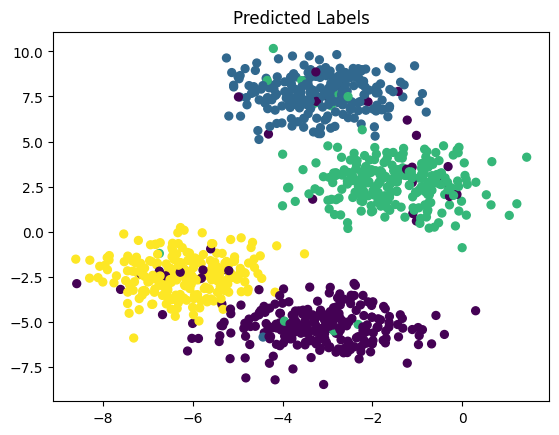

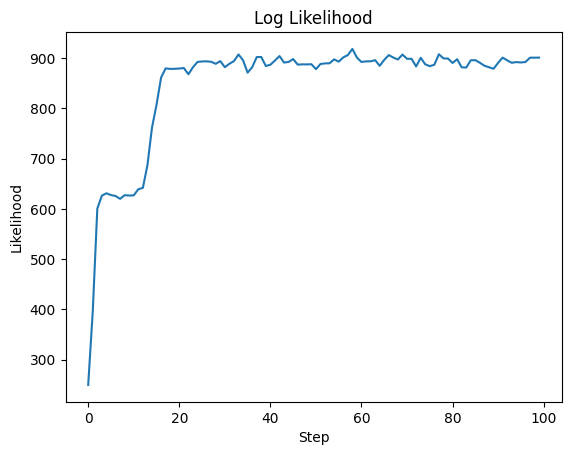

In [33]:
ALPHA = 1.
ETA = 1.
SIGMA = 1.
INIT_RANDOM = True
N_STEPS = 100

model = GibbsGMM(N_TOPICS, ALPHA, ETA, SIGMA, INIT_RANDOM).fit(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.labels_)
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')
util.visualize_log(model.likelihood_log_, 'Log Likelihood', 'Step', 'Likelihood')

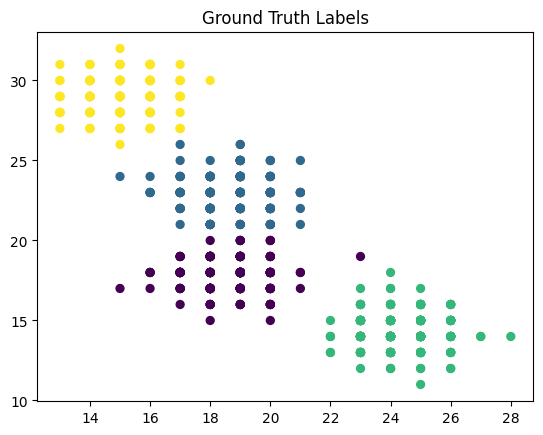

In [6]:
N_SAMPLES = 1000
N_FEATURES = 100
N_TOPICS = 4
SCALE = 1
DISCRETIZE = True
SHUFFLE = True

if DISCRETIZE:
    X, X_labels, vocab = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
else:
    X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

100%|██████████| 100/100 [00:01<00:00, 53.54it/s]


Score: 0.939


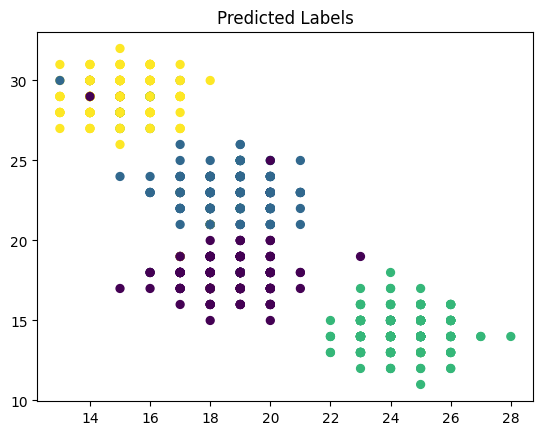

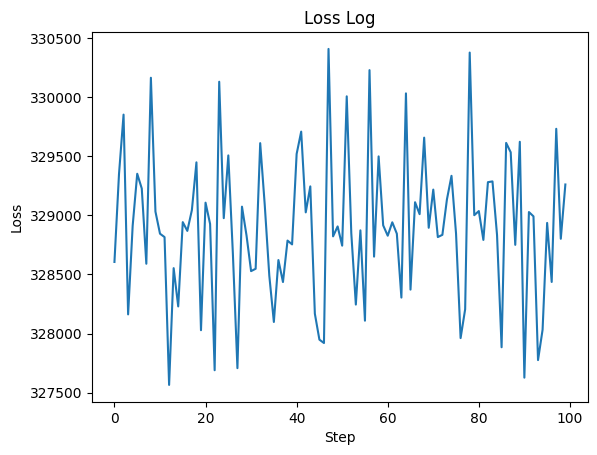

In [15]:
VOCAB_SIZE = vocab.shape[0]
BATCH_SIZE = X.shape[0]//10
N_STEPS = 100
LEARNING_RATE = 1e-1

Y = torch.tensor(X).T
model = PyroLDA(N_TOPICS, VOCAB_SIZE, BATCH_SIZE).fit(Y, N_STEPS, LEARNING_RATE)
Y_labels, score = util.evaluate(X_labels, model.transform().detach().numpy())
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')
util.visualize_log(model.loss_log_, 'Loss Log', 'Step', 'Loss')